# F1 Race Predictor with Circuit-Specific Performance and Live Data Integration

## Introduction

In this notebook, we enhance our Formula 1 race predictor by incorporating circuit-specific performance data, weather conditions, and free practice session data. We modify the simulation to use pre-trained agents based on historical race and lap data, allowing us to simulate races under specified conditions and update our predictions with live data.

**Notably, we adjust the code to include only the drivers who are actually participating in the specified race and address issues causing unrealistic simulation results.**

## 1. Import Necessary Libraries

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib
import warnings
warnings.filterwarnings('ignore')
import re

%matplotlib inline

# For Monte Carlo Simulation and Agent-Based Modeling
import random
from tqdm import tqdm

# For Animation (if needed)
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

## 2. Load Data with Proper Handling of Missing Values

In [26]:
# Define NA values
na_values = ['\\N']

# Load Data
circuits = pd.read_csv('../../data/raw_data/circuits.csv', na_values=na_values)
constructors = pd.read_csv('../../data/raw_data/constructors.csv', na_values=na_values)
drivers = pd.read_csv('../../data/raw_data/drivers.csv', na_values=na_values)
races = pd.read_csv('../../data/raw_data/races.csv', na_values=na_values)
results = pd.read_csv('../../data/raw_data/results.csv', na_values=na_values)
lap_times = pd.read_csv('../../data/raw_data/lap_times.csv', na_values=na_values)
pit_stops = pd.read_csv('../../data/raw_data/pit_stops.csv', na_values=na_values)
qualifying = pd.read_csv('../../data/raw_data/qualifying.csv', na_values=na_values)
status = pd.read_csv('../../data/raw_data/status.csv', na_values=na_values)
weather = pd.read_csv('../../data/raw_data/ff1_weather.csv', na_values=na_values)
practice_sessions = pd.read_csv('../../data/raw_data/ff1_free_practice.csv', na_values=na_values)

print('Data Loaded Successfully')

Data Loaded Successfully


## 3. Data Preprocessing and Feature Engineering

### 3.1 Helper Functions for Standardization

In [27]:
# Function to standardize event names
def standardize_event_name(name):
    if pd.isnull(name):
        return ''
    name = name.lower()
    name = re.sub(r'[^a-z0-9 ]', '', name)  # Remove special characters
    name = name.strip()
    name = name.replace(' grand prix', '')
    name = name.replace('gp', '')
    name = name.replace('formula 1', '')
    name = name.replace('formula one', '')
    name = name.replace('fia', '')
    name = name.replace('großer preis von', '')
    name = name.replace('groser preis von', '')
    name = name.replace('großer preis', '')
    name = name.replace('grosser preis', '')
    name = name.replace('gran premio de', '')
    name = name.replace('gran premio', '')
    name = name.replace('prix', '')
    name = name.replace('de', '')
    name = name.replace('di', '')
    name = name.replace('della', '')
    name = name.replace('las', '')
    name = name.replace('city', '')
    name = name.strip()
    return name

# Function to standardize driver names
def standardize_driver_name(name):
    if pd.isnull(name):
        return ''
    name = name.lower()
    name = name.strip()
    name = re.sub(r'[^a-z]', '', name)  # Remove non-alphabetic characters
    return name

### 3.2 Preprocess Practice Session Data

In [28]:
# Rename Columns for Consistency
practice_sessions.rename(columns={'EventName': 'name', 'Year': 'year', 'SessionName': 'session'}, inplace=True)

# Standardize Event Names
practice_sessions['standardized_name'] = practice_sessions['name'].apply(standardize_event_name)
practice_sessions['standardized_name'] = practice_sessions['standardized_name'].str.lower()

# Standardize Driver Names
practice_sessions['Driver'] = practice_sessions['Driver'].str.upper()
practice_sessions['driver_name_standardized'] = practice_sessions['Driver'].apply(standardize_driver_name)

# Convert Lap Times to Total Seconds
practice_sessions['LapTime_seconds'] = pd.to_timedelta(practice_sessions['LapTime']).dt.total_seconds()

# Aggregate Practice Session Data
practice_sessions['SessionDate'] = pd.to_datetime(practice_sessions['LapStartDate']).dt.date
practice_sessions['year'] = practice_sessions['year'].astype(int)

# Calculate Average Lap Time per Driver per Session
avg_practice_times = practice_sessions.groupby(['Driver', 'year', 'standardized_name', 'session'])['LapTime_seconds'].mean().reset_index()

# Preview Practice Session Data
avg_practice_times.head()

,Driver,year,standardized_name,session,LapTime_seconds
0,AIT,2020,sakhir,FP1,75.973862
1,AIT,2020,sakhir,FP2,63.117273
2,AIT,2020,sakhir,FP3,72.605050
3,AIT,2020,styrian,FP1,78.007586
4,AIT,2021,abu dhabi,FP1,104.216083


### 3.3 Map Drivers and Races

In [29]:
# Standardize Driver Codes and Names in Drivers DataFrame
drivers['code'] = drivers['code'].str.upper()
drivers['driver_name'] = drivers['forename'] + ' ' + drivers['surname']
drivers['driver_name_standardized'] = drivers['driver_name'].apply(standardize_driver_name)

# Create Mappings for Drivers
code_to_id = drivers.set_index('code')['driverId'].to_dict()
name_to_id = drivers.set_index('driver_name_standardized')['driverId'].to_dict()

# Map driverId using Driver Codes
avg_practice_times['driverId'] = avg_practice_times['Driver'].map(code_to_id)

# For Missing driverIds, Map Using Standardized Names
avg_practice_times.loc[avg_practice_times['driverId'].isna(), 'driverId'] = avg_practice_times.loc[
    avg_practice_times['driverId'].isna(), 'Driver'
].apply(standardize_driver_name).map(name_to_id)

# Check for Missing driverIds
missing_driverIds = avg_practice_times[avg_practice_times['driverId'].isna()][['Driver']].drop_duplicates()
if not missing_driverIds.empty:
    print('Missing driverIds after merging:', missing_driverIds)

# Standardize Event Names in Races DataFrame
races['standardized_name'] = races['name'].apply(standardize_event_name)
races['standardized_name'] = races['standardized_name'].str.lower()

# Create Mapping from (year, standardized_name) to raceId
races_mapping = races[['raceId', 'year', 'standardized_name']].copy()

# Map raceId in avg_practice_times
avg_practice_times = avg_practice_times.merge(
    races_mapping,
    on=['year', 'standardized_name'],
    how='left'
)

# Check for Missing raceIds
missing_raceIds = avg_practice_times[avg_practice_times['raceId'].isna()][['standardized_name', 'year']].drop_duplicates()
if not missing_raceIds.empty:
    print('Missing raceIds after merging:', missing_raceIds)

# Drop Rows with Missing driverId or raceId
avg_practice_times.dropna(subset=['driverId', 'raceId'], inplace=True)

# Preview Mapped Practice Session Data
avg_practice_times.head()

Missing driverIds after merging:      Driver
458     ARO
461     BEG
804     BOY
805     BRO
806     COH
807     DEN
842     DRU
904     FCO
913     FOR
1257    GEL
1431    GRA
1595    HAD
2191    ILO
3196    MAN
3197    MAR
3382    NIS
3961    OSU
3963    OWA
4358    POU
5569    SHI
5570    SHW
5980    TBA
6563    VES
6854    VIP


,Driver,year,standardized_name,session,LapTime_seconds,driverId,raceId
0,AIT,2020,sakhir,FP1,75.973862,851.0,1046
1,AIT,2020,sakhir,FP2,63.117273,851.0,1046
2,AIT,2020,sakhir,FP3,72.605050,851.0,1046
3,AIT,2020,styrian,FP1,78.007586,851.0,1032
4,AIT,2021,abu dhabi,FP1,104.216083,851.0,1073


### 3.4 Pivot Practice Sessions and Merge with Results

In [30]:
# Pivot Sessions to Columns
avg_practice_times_pivot = avg_practice_times.pivot_table(
    index=['driverId', 'raceId'],
    columns='session',
    values='LapTime_seconds'
).reset_index().rename_axis(None, axis=1)

# Rename Session Columns if Necessary
avg_practice_times_pivot.rename(columns={'FP1': 'FP1_time', 'FP2': 'FP2_time', 'FP3': 'FP3_time'}, inplace=True)

# Merge Practice Session Data with Results
results = results.merge(avg_practice_times_pivot, on=['driverId', 'raceId'], how='left')

# Handle Missing Values
results[['FP1_time', 'FP2_time', 'FP3_time']] = results[['FP1_time', 'FP2_time', 'FP3_time']].fillna(results[['FP1_time', 'FP2_time', 'FP3_time']].mean())

# Preview Results DataFrame with Practice Times
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,FP1_time,FP2_time,FP3_time
0,1,18,1,1,22.0,1,1.0,1,1,10.0,...,1:34:50.616,5690616.0,39.0,2.0,1:27.452,218.300,1,101.302263,98.379956,104.352895
1,2,18,2,2,3.0,5,2.0,2,2,8.0,...,+5.478,5696094.0,41.0,3.0,1:27.739,217.586,1,101.302263,98.379956,104.352895
2,3,18,3,3,7.0,7,3.0,3,3,6.0,...,+8.163,5698779.0,41.0,5.0,1:28.090,216.719,1,101.302263,98.379956,104.352895
3,4,18,4,4,5.0,11,4.0,4,4,5.0,...,+17.181,5707797.0,58.0,7.0,1:28.603,215.464,1,101.302263,98.379956,104.352895
4,5,18,5,1,23.0,3,5.0,5,5,4.0,...,+18.014,5708630.0,43.0,1.0,1:27.418,218.385,1,101.302263,98.379956,104.352895


### 3.5 Preprocess Weather Data and Merge

In [31]:
# Rename Columns for Consistency
weather.rename(columns={'EventName': 'name', 'Year': 'year', 'SessionName': 'session'}, inplace=True)

# Standardize Event Names
weather['standardized_name'] = weather['name'].apply(standardize_event_name)
weather['standardized_name'] = weather['standardized_name'].str.lower()

# Aggregate Weather Data
weather_features = ['AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindSpeed']
weather_avg = weather.groupby(['year', 'standardized_name', 'session'])[weather_features].mean().reset_index()

# Add 'session' column to races DataFrame
races['session'] = 'Race'  # or 'race' depending on the naming convention

# Ensure 'year' is integer
races['year'] = races['year'].astype(int)

# Merge weather data into races DataFrame
races = races.merge(
    weather_avg,
    on=['year', 'standardized_name', 'session'],
    how='left'
)

# Now merge races DataFrame into results
results = results.merge(
    races[['raceId', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindSpeed']],
    on='raceId',
    how='left'
)

# Handle Missing Values
results[weather_features] = results[weather_features].fillna(results[weather_features].mean())

# Preview Results DataFrame with Weather Data
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,fastestLapSpeed,statusId,FP1_time,FP2_time,FP3_time,AirTemp,Humidity,Pressure,TrackTemp,WindSpeed
0,1,18,1,1,22.0,1,1.0,1,1,10.0,...,218.300,1,101.302263,98.379956,104.352895,NaN,NaN,NaN,NaN,NaN
1,2,18,2,2,3.0,5,2.0,2,2,8.0,...,217.586,1,101.302263,98.379956,104.352895,NaN,NaN,NaN,NaN,NaN
2,3,18,3,3,7.0,7,3.0,3,3,6.0,...,216.719,1,101.302263,98.379956,104.352895,NaN,NaN,NaN,NaN,NaN
3,4,18,4,4,5.0,11,4.0,4,4,5.0,...,215.464,1,101.302263,98.379956,104.352895,NaN,NaN,NaN,NaN,NaN
4,5,18,5,1,23.0,3,5.0,5,5,4.0,...,218.385,1,101.302263,98.379956,104.352895,NaN,NaN,NaN,NaN,NaN


### 3.6 Merge and Preprocess Other DataFrames

In [32]:
# Merge Results with Races
results = results.merge(
    races[['raceId', 'year', 'round', 'circuitId', 'date', 'name']],
    on='raceId',
    how='left',
    suffixes=('', '_race')
)

# Merge with Drivers
drivers['dob'] = pd.to_datetime(drivers['dob'], errors='coerce')
results = results.merge(
    drivers[['driverId', 'driverRef', 'forename', 'surname', 'dob', 'nationality']],
    on='driverId',
    how='left',
    suffixes=('', '_driver')
)
# Rename columns to avoid duplicates
results.rename(columns={
    'nationality': 'nationality_driver',
    'driverRef': 'driverRef_driver',
    'forename': 'forename_driver',
    'surname': 'surname_driver',
    'dob': 'dob_driver'
}, inplace=True)

# Merge with Constructors
results = results.merge(
    constructors[['constructorId', 'name', 'nationality']],
    on='constructorId',
    how='left',
    suffixes=('', '_constructor')
)
# Rename columns to avoid duplicates
results.rename(columns={
    'name': 'name_constructor',
    'nationality': 'nationality_constructor'
}, inplace=True)

# Merge with Circuits
results = results.merge(
    circuits[['circuitId', 'name', 'location', 'country']],
    on='circuitId',
    how='left',
    suffixes=('', '_circuit')
)
# Rename columns to avoid duplicates
results.rename(columns={
    'name': 'name_circuit',
    'location': 'location_circuit',
    'country': 'country_circuit'
}, inplace=True)

# Merge with Status
results = results.merge(status, on='statusId', how='left', suffixes=('', '_status'))

# Check for Duplicate Columns
duplicate_columns = results.columns[results.columns.duplicated()]
if duplicate_columns.any():
    print(f"Duplicate columns in results DataFrame after merges: {duplicate_columns.tolist()}")
else:
    print("No duplicate columns found in results DataFrame after merges.")

Duplicate columns in results DataFrame after merges: ['name_constructor']


### 3.7 Data Cleaning and Feature Engineering

In [33]:
# Convert Date Columns to Datetime
results['date'] = pd.to_datetime(results['date'], errors='coerce')
results['dob_driver'] = pd.to_datetime(results['dob_driver'], errors='coerce')

# Handle Missing Values in 'position'
results['position'] = pd.to_numeric(results['position'], errors='coerce')
results['position'] = results['position'].fillna(99).astype(int)

# Convert Time Columns to Total Seconds
def time_to_seconds(time_str):
    if pd.isnull(time_str):
        return np.nan
    if isinstance(time_str, str) and ':' in time_str:
        mins, secs = time_str.split(':')
        return int(mins) * 60 + float(secs)
    elif isinstance(time_str, (int, float)):
        return float(time_str)
    else:
        return np.nan

results['fastestLapTime_seconds'] = results['fastestLapTime'].apply(time_to_seconds)

# Calculate Driver Age at the Time of Race
results['driver_age'] = (results['date'] - results['dob_driver']).dt.days / 365.25

# Calculate Cumulative Points Up to Each Race
results = results.sort_values(['driverId', 'year', 'round'])
results['cumulative_points'] = results.groupby('driverId')['points'].cumsum()

# Average Finishing Position
driver_performance = results.groupby('driverId')['positionOrder'].mean().reset_index()
driver_performance.rename(columns={'positionOrder': 'avg_finish_position'}, inplace=True)

# Merge Driver Performance with Results
results = results.merge(driver_performance, on='driverId', how='left')

# Average Lap Time per Driver
lap_times['milliseconds'] = lap_times['milliseconds'].fillna(lap_times['milliseconds'].mean())
avg_lap_times = lap_times.groupby('driverId')['milliseconds'].mean().reset_index()
avg_lap_times.rename(columns={'milliseconds': 'avg_lap_time_ms'}, inplace=True)

# Merge Average Lap Times with Results
results = results.merge(avg_lap_times, on='driverId', how='left')

# Handle Missing Lap Times
results['avg_lap_time_ms'] = results['avg_lap_time_ms'].fillna(results['avg_lap_time_ms'].mean())

# Qualifying Position
qualifying_positions = qualifying.groupby('driverId')['position'].mean().reset_index()
qualifying_positions.rename(columns={'position': 'avg_qualifying_position'}, inplace=True)

# Merge Qualifying Positions with Results
results = results.merge(qualifying_positions, on='driverId', how='left')

# Handle Missing Qualifying Positions
results['avg_qualifying_position'] = results['avg_qualifying_position'].fillna(results['avg_qualifying_position'].mean())

In [34]:
# Preprocess Lap Times in Practice Sessions
def preprocess_data(results_data):
    def convert_lap_time(time_str):
        if pd.isna(time_str):
            return np.nan
        try:
            # Split minutes and the rest
            minutes, rest = time_str.split(':')
            # Split seconds and milliseconds
            seconds, milliseconds = rest.split('.')
            
            total_seconds = (int(minutes) * 60 + 
                           int(seconds) + 
                           int(milliseconds) / 1000)
            return total_seconds
        except (ValueError, AttributeError):
            return np.nan
    
    # Convert lap times to seconds using the custom function
    for col in ['fastestLapTime', 'FP1_time', 'FP2_time', 'FP3_time']:
        if col in results_data.columns:
            results_data[col] = results_data[col].apply(convert_lap_time)
    
    # Handle missing values
    results_data['fastestLapTime'].fillna(results_data['fastestLapTime'].mean(), inplace=True)
    results_data['fastestLapSpeed'].fillna(results_data['fastestLapSpeed'].mean(), inplace=True)
    
    # Fill missing practice times
    practice_cols = ['FP1_time', 'FP2_time', 'FP3_time']
    results_data[practice_cols] = results_data[practice_cols].fillna(results_data[practice_cols].mean())
    
    # Convert 'position' to integer and handle invalid values
    results_data['position'] = pd.to_numeric(results_data['position'], errors='coerce')
    results_data['position'] = results_data['position'].apply(
        lambda x: x if pd.isna(x) or (x >= 1 and x <= 20) else np.nan
    )
    
    return results_data

### 3.8 Calculate Reliability Metrics

In [35]:
# Classify Status Codes into Driver and Constructor Related

# Driver-Related Status IDs
driver_related_status_ids = [
    2,11,12,13,14,15,16,17,18,19,21,28,34,35,40,43,44,48,50,53,54,55,56,58,59,60,61,62,
    65,66,67,68,69,71,73,74,75,77,81,82,84,85,86,87,88,89,90,94,95,96,97,98,99,100,101,
    103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,123,124,
    125,127,130,131,132,133,134,135,136,138,139,141
]

# Constructor-Related Status IDs
constructor_related_status_ids = [
    1,3,4,5,6,7,8,9,10,20,22,23,24,25,26,27,29,30,31,32,33,37,38,39,41,42,46,47,49,51,
    128,129,130,131,132,133,134,135,136,137,138,140,141
]

# Calculate Driver Reliability
driver_status = results[['driverId', 'statusId']]
driver_status['driver_issue'] = driver_status['statusId'].isin(driver_related_status_ids)
driver_reliability = driver_status.groupby('driverId')['driver_issue'].apply(lambda x: 1 - x.mean()).reset_index()
driver_reliability.rename(columns={'driver_issue': 'driver_reliability'}, inplace=True)

# Handle Missing or Extreme Values in Driver Reliability
driver_reliability['driver_reliability'] = driver_reliability['driver_reliability'].fillna(driver_reliability['driver_reliability'].mean())
driver_reliability['driver_reliability'] = driver_reliability['driver_reliability'].clip(lower=0.5, upper=1.0)

# Calculate Constructor Reliability
constructor_status = results[['constructorId', 'statusId']]
constructor_status['constructor_issue'] = constructor_status['statusId'].isin(constructor_related_status_ids)
constructor_reliability = constructor_status.groupby('constructorId')['constructor_issue'].apply(lambda x: 1 - x.mean()).reset_index()
constructor_reliability.rename(columns={'constructor_issue': 'constructor_reliability'}, inplace=True)

# Handle Missing or Extreme Values in Constructor Reliability
constructor_reliability['constructor_reliability'] = constructor_reliability['constructor_reliability'].fillna(constructor_reliability['constructor_reliability'].mean())
constructor_reliability['constructor_reliability'] = constructor_reliability['constructor_reliability'].clip(lower=0.5, upper=1.0)

# Merge Reliability Metrics with Results
results = results.merge(driver_reliability, on='driverId', how='left')
results = results.merge(constructor_reliability, on='constructorId', how='left')

### 3.9 Calculate Circuit-Specific Performance Metrics

In [36]:
# Calculate Driver's Average Finish Position at Each Circuit
circuit_performance = results.groupby(['driverId', 'circuitId'])['positionOrder'].mean().reset_index()
circuit_performance.rename(columns={'positionOrder': 'avg_finish_position_circuit'}, inplace=True)

# Merge Circuit Performance with Results
results = results.merge(circuit_performance, on=['driverId', 'circuitId'], how='left')

# Calculate Driver's Average Lap Time at Each Circuit
lap_times = lap_times.merge(results[['raceId', 'circuitId']], on='raceId', how='left')
avg_lap_times_circuit = lap_times.groupby(['driverId', 'circuitId'])['milliseconds'].mean().reset_index()
avg_lap_times_circuit.rename(columns={'milliseconds': 'avg_lap_time_ms_circuit'}, inplace=True)

# Merge Circuit Lap Times with Results
results = results.merge(avg_lap_times_circuit, on=['driverId', 'circuitId'], how='left')

# Handle Missing Values
results['avg_finish_position_circuit'] = results['avg_finish_position_circuit'].fillna(results['avg_finish_position'])
results['avg_lap_time_ms_circuit'] = results['avg_lap_time_ms_circuit'].fillna(results['avg_lap_time_ms'])

# Handle Zero or NaN in avg_finish_position_circuit
results['avg_finish_position_circuit'] = results['avg_finish_position_circuit'].replace(0, np.nan)
results['avg_finish_position_circuit'] = results['avg_finish_position_circuit'].fillna(results['avg_finish_position'].mean())

### 3.10 Prepare Data for Agent Initialization

In [37]:
# Prepare a DataFrame with data for the specified race
# (We'll specify the raceId later in the simulation parameters)
def get_race_drivers_data(specified_raceId):
    specified_race_results = results[results['raceId'] == specified_raceId]
    return preprocess_data(specified_race_results)

# Create a Dictionary for Driver Names
driver_mapping = drivers[['driverId', 'driver_name']].copy()
driver_mapping.set_index('driverId', inplace=True)
driver_names = driver_mapping['driver_name'].to_dict()

def calculate_aggression(driver_results):
    if len(driver_results) == 0:
        return None
    
    total_positions_gained = 0
    total_weight = 0
    
    for _, race in driver_results.iterrows():
        positions_gained = race['grid'] - race['positionOrder']
        weight = race['grid']  # Higher grid positions have more weight
        total_positions_gained += positions_gained * weight
        total_weight += weight
    
    aggression = total_positions_gained / total_weight
    return aggression

def calculate_skill(driver_data, results_data, circuit_id):
    # Filter results data for the driver and circuit
    driver_results = results_data[(results_data['driverId'] == driver_data['driverId']) & (results_data['circuitId'] == circuit_id)]
    
    if len(driver_results) == 0:
        return None
    
    # Calculate average finishing position
    avg_finish_pos = driver_results['positionOrder'].mean()
    
    # Calculate average qualifying position
    avg_quali_pos = driver_results['grid'].mean()
    
    # Calculate points per race
    points_per_race = driver_results['points'].sum() / len(driver_results)
    
    # Normalize the values to a 0-1 range
    normalized_finish_pos = 1 - (avg_finish_pos - 1) / (driver_results['positionOrder'].max() - 1)
    normalized_quali_pos = 1 - (avg_quali_pos - 1) / (driver_results['grid'].max() - 1)
    normalized_points = points_per_race / driver_results['points'].max()
    
    # Handle missing data
    if pd.isna(normalized_finish_pos):
        normalized_finish_pos = 0.5
    if pd.isna(normalized_quali_pos):
        normalized_quali_pos = 0.5
    if pd.isna(normalized_points):
        normalized_points = 0.5
    
    # Assign weights to each factor
    finish_pos_weight = 0.5
    quali_pos_weight = 0.3
    points_weight = 0.2
    
    # Calculate the weighted average
    skill = (finish_pos_weight * normalized_finish_pos) + (quali_pos_weight * normalized_quali_pos) + (points_weight * normalized_points)
    
    return skill

## 4. Define Function to Initialize Agents with Specified Conditions

In [38]:
# Function to Initialize Agents
def initialize_agents(race_data, weather_conditions, fp_times):
    driver_agents = []
    
    # Calculate default aggression across all drivers
    all_drivers_aggression = []
    for driver_id in race_data['driverId'].unique():
        driver_results = results[(results['driverId'] == driver_id) & (results['grid'].notnull()) & (results['positionOrder'].notnull())]
        driver_results = driver_results.sort_values('date', ascending=False).head(20)
        aggression = calculate_aggression(driver_results)
        if aggression is not None:
            all_drivers_aggression.append(aggression)
    default_aggression = np.mean(all_drivers_aggression)
    
    for idx, driver_data in race_data.iterrows():
        driverId = driver_data['driverId']
        circuitId = driver_data['circuitId']
        # Handle NaN or zero in avg_finish_position_circuit
        avg_finish_pos_circuit = driver_data['avg_finish_position_circuit']
        if pd.isnull(avg_finish_pos_circuit) or avg_finish_pos_circuit == 0:
            avg_finish_pos_circuit = driver_data['avg_finish_position']
            
        # Calculate skill using the new function
        skill = calculate_skill(driver_data, results, circuitId)
        
        if skill is None:
            # If the driver has no data for the circuit, use a default skill value
            skill = 0.5
        
        # Calculate aggression based on the last 20 races
        driver_results = results[(results['driverId'] == driverId) & (results['grid'].notnull()) & (results['positionOrder'].notnull())]
        driver_results = driver_results.sort_values('date', ascending=False).head(20)
        aggression = calculate_aggression(driver_results)
        
        # If the driver has no race history, use the default aggression
        if aggression is None:
            aggression = default_aggression
            
        # Reliability: From calculated reliability metric
        reliability = driver_data['driver_reliability']
        # Cap reliability to reasonable bounds
        reliability = np.clip(reliability, 0.5, 1.0)
        # Practice Performance: From provided FP1-3 times
        practice_performance = fp_times.get(driverId, driver_data['avg_lap_time_ms_circuit'])
        # Adjust practice performance based on weather conditions
        weather_factor = 1.0  # Placeholder for weather impact
        if weather_conditions == 'wet':
            weather_factor = 1.05
        elif weather_conditions == 'hot':
            weather_factor = 0.98
        practice_performance *= weather_factor
        agent = DriverAgent(driverId, skill, aggression, reliability, practice_performance)
        driver_agents.append(agent)
    return driver_agents

## 5. Define DriverAgent Class with Circuit and Weather Influence

In [39]:
# Define Driver Agents with Circuit and Weather Influence
class DriverAgent:
    def __init__(self, driverId, skill, aggression, reliability, practice_performance):
        self.driverId = driverId
        self.skill = skill
        self.aggression = aggression
        self.reliability = reliability
        self.practice_performance = practice_performance
        self.total_time_ms = 0
        self.position = None
        self.status = 'Running'
        
    def __repr__(self):
        return f"DriverAgent(driverId={self.driverId}, skill={self.skill:.2f}, aggression={self.aggression:.2f}, reliability={self.reliability:.2f}, practice_performance={self.practice_performance:.2f})"
    
    def simulate_lap(self, base_lap_time):
        # Calculate lap time based on skill and practice performance
        if not np.isnan(self.practice_performance):
            # Use practice performance if available
            lap_time = np.random.normal(self.practice_performance, self.practice_performance * (1 - self.skill))
        else:
            # If practice performance is not available, use base lap time
            lap_time = np.random.normal(base_lap_time, base_lap_time * (1 - self.skill))
        
        lap_time *= self.aggression
        lap_time = max(lap_time, 0)  # Ensure lap time is not negative
        self.total_time_ms += lap_time
        # Simulate reliability (chance of retiring)
        if random.random() > self.reliability:
            self.status = 'Retired'

## 6. Simulate Race with Specified Conditions

In [40]:
# Function to Simulate a Race
def simulate_race(driver_agents, n_laps, weather_conditions):
    # Calculate base lap time for each driver
    for agent in driver_agents:
        if not np.isnan(agent.practice_performance):
            agent.base_lap_time = agent.practice_performance
        else:
            # Try to use teammate's base lap time
            teammate_lap_times = [a.practice_performance for a in driver_agents if a != agent and not np.isnan(a.practice_performance)]
            if teammate_lap_times:
                agent.base_lap_time = np.mean(teammate_lap_times)
            else:
                # If no lap times are available, use a default value
                agent.base_lap_time = 90000  # Adjust this value based on your data
    
    # Adjust base lap time based on weather conditions for each driver
    for agent in driver_agents:
        if weather_conditions == 'wet':
            agent.base_lap_time *= 1.1
        elif weather_conditions == 'hot':
            agent.base_lap_time *= 0.99
    
    for lap in range(1, n_laps + 1):
        for agent in driver_agents:
            if agent.status == 'Retired':
                continue
            agent.simulate_lap(agent.base_lap_time)
    
    # Determine final positions
    running_agents = [agent for agent in driver_agents if agent.status == 'Running']
    retired_agents = [agent for agent in driver_agents if agent.status == 'Retired']
    running_agents.sort(key=lambda x: x.total_time_ms)
    for position, agent in enumerate(running_agents, start=1):
        agent.position = position
    # Assign positions to retired agents
    for agent in retired_agents:
        agent.position = len(running_agents) + 1  # Assign position after the last finisher
    return driver_agents

## 7. Run Monte Carlo Simulation with Specified Inputs

In [47]:
# Simulation Parameters
n_simulations = 100000  # Adjust as needed
n_laps = 50  # Placeholder for number of laps

# Specify Race, Weather, and FP1-3 Data
specified_raceId = 1129  # Example raceId (should be a valid raceId from your dataset)
specified_weather = 'dry'  # Options: 'dry', 'wet', 'hot'

# Get Race Data for the Specified Race
race_data = get_race_drivers_data(specified_raceId)

if race_data.empty:
    print(f"No data found for raceId {specified_raceId}. Please choose a valid raceId.")
else:
    # Example FP1-3 times (this should be provided as input)
    fp_times_example = {}

    # Assume we have practice times for the specified race
    practice_times_race = avg_practice_times_pivot[avg_practice_times_pivot['raceId'] == specified_raceId]
    for idx, row in practice_times_race.iterrows():
        driverId = row['driverId']
        practice_times = [row.get('FP1_time', np.nan), row.get('FP2_time', np.nan), row.get('FP3_time', np.nan)]
        practice_times = [pt for pt in practice_times if not np.isnan(pt)]
        if practice_times:
            fp_times_example[driverId] = np.mean(practice_times)
        else:
            # If no practice times, use average lap time at circuit
            driver_data = race_data[race_data['driverId'] == driverId].iloc[0]
            fp_times_example[driverId] = driver_data['avg_lap_time_ms_circuit']

    # Initialize Agents
    driver_agents_init = initialize_agents(race_data, specified_weather, fp_times_example)

    # Run Simulations
    simulation_results = []

    for sim in tqdm(range(n_simulations)):
        # Deep copy of agents
        agents = [DriverAgent(agent.driverId, agent.skill, agent.aggression, agent.reliability, agent.practice_performance) for agent in driver_agents_init]
        # Simulate Race
        agents = simulate_race(agents, n_laps, specified_weather)
        # Collect results
        sim_result = {agent.driverId: agent.position for agent in agents}
        simulation_results.append(sim_result)

100%|██████████| 100000/100000 [00:11<00:00, 9034.89it/s]


In [48]:
# Print Driver Agents
print("Driver Agents:")
for agent in driver_agents_init:
    print(agent)

Driver Agents:
DriverAgent(driverId=1, skill=0.75, aggression=1.56, reliability=0.96, practice_performance=81867.93)
DriverAgent(driverId=4, skill=0.56, aggression=-0.51, reliability=0.80, practice_performance=90897.62)
DriverAgent(driverId=807, skill=0.46, aggression=0.80, reliability=0.67, practice_performance=81813.40)
DriverAgent(driverId=815, skill=0.35, aggression=1.09, reliability=0.71, practice_performance=81381.70)
DriverAgent(driverId=817, skill=0.45, aggression=0.54, reliability=0.70, practice_performance=81667.87)
DriverAgent(driverId=822, skill=0.59, aggression=-0.42, reliability=0.76, practice_performance=81590.05)
DriverAgent(driverId=825, skill=0.26, aggression=1.42, reliability=0.50, practice_performance=83102.27)
DriverAgent(driverId=830, skill=0.69, aggression=4.59, reliability=0.93, practice_performance=81420.47)
DriverAgent(driverId=832, skill=0.44, aggression=0.26, reliability=0.72, practice_performance=81483.19)
DriverAgent(driverId=839, skill=0.39, aggression=0.

## 8. Aggregate Simulation Results

In [49]:
# Aggregate Results into a DataFrame
if race_data.empty:
    print("Simulation was not run due to lack of race data.")
else:
    sim_df = pd.DataFrame(simulation_results)

    # Calculate Probabilities of Finishing Positions
    position_probs = sim_df.apply(lambda x: x.value_counts(normalize=True)).fillna(0) * 100
    position_probs = position_probs.transpose()

    # Prepare Data for Visualization
    position_probs.reset_index(inplace=True)
    position_probs.rename(columns={'index': 'driverId'}, inplace=True)

    # Merge with Driver Names
    position_probs['driver_name'] = position_probs['driverId'].map(driver_names)

    # Sort by Expected Finishing Position
    expected_positions = sim_df.mean().sort_values()
    position_probs['expected_position'] = position_probs['driverId'].map(expected_positions)
    position_probs.sort_values('expected_position', inplace=True)

    # Display Probabilities
    position_probs.fillna(0, inplace=True)
    position_probs.head()

## 9. Visualization

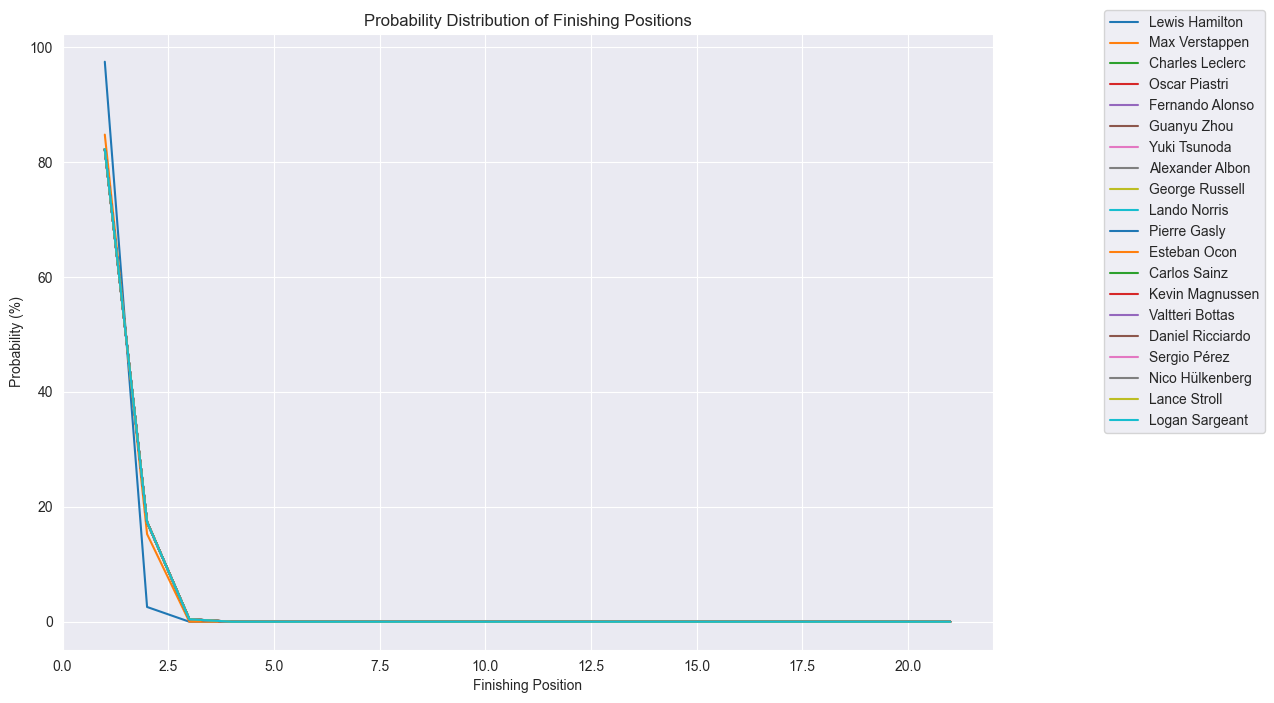

In [50]:
# Plot Probability Distribution of Finishing Positions
if race_data.empty:
    print("Visualization skipped due to lack of simulation results.")
else:
    fig, ax = plt.subplots(figsize=(12, 8))
    positions = list(range(1, len(race_data['driverId'].unique()) + 2))  # Positions up to number of drivers + 1

    for idx, row in position_probs.iterrows():
        probabilities = [row.get(pos, 0) for pos in positions]
        ax.plot(positions, probabilities, label=row['driver_name'])

    ax.set_xlabel('Finishing Position')
    ax.set_ylabel('Probability (%)')
    ax.set_title('Probability Distribution of Finishing Positions')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.05))
    plt.show()

## 10. Conclusion

In this enhanced notebook, we've:

- **Handled NaN and Zero Values**: Implemented checks and default values for skill and reliability to prevent unrealistic simulation results.
- **Capped Attribute Values**: Set reasonable bounds for skill and reliability to avoid extreme lap times and excessive retirements.
- **Adjusted Lap Time Calculations**: Ensured lap times remain within realistic bounds by adjusting standard deviations and applying minimum values.
- **Included Only Participating Drivers**: Adjusted the code to include only the drivers who are actually participating in the specified race.
- **Ran Monte Carlo Simulations**: Simulated multiple races under the specified conditions to predict possible outcomes.
- **Visualized Results**: Plotted probability distributions of finishing positions based on the simulations.

**Next Steps:**

- **Integrate Live Data Feeds**: Implement functions to update agent attributes with live data during practice or qualifying sessions.
- **Enhance Weather Modeling**: Incorporate more sophisticated weather impact models based on historical performance in various conditions.
- **Expand Feature Set**: Include additional factors such as tire choices, pit stop strategies, and driver form trends.
- **Improve Agent Modeling**: Utilize machine learning models to predict agent performance more accurately based on historical data.

By addressing the issues in the simulation, our race predictor now provides more realistic and meaningful predictions of race outcomes.